In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from numba import njit
import time

In [3]:
!pip install --upgrade quantecon
#import quantecon as qe
from quantecon import markov, MarkovChain
from math import erfc, sqrt

Requirement already up-to-date: quantecon in c:\users\woute\anaconda3\lib\site-packages (0.4.5)


**EXERCISE 2 - SETUP**

In [4]:
θ = 0.21
ν = 0.64
δ = 0.1
β = 0.96
ϕ = 0.5

In [5]:
ρ = 0.9   ## SETTING UP THE MARKOV PROBAILITIES AND STATES FOR WHAT FOLLOWS
σ = 0.02

MC = markov.approximation.tauchen(ρ, σ, n=10).P
print("The matrix of transition probabilities is:", MC)
x = markov.approximation.tauchen(ρ, σ, n=10).state_values
print("The states are:", x)

The matrix of transition probabilities is: [[5.30478170e-01 4.15375002e-01 5.32885772e-02 8.56706028e-04
  1.54439460e-06 2.92857183e-10 5.66213743e-15 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.67966302e-02 4.93930466e-01 3.69971746e-01 3.87971726e-02
  5.03259844e-04 7.25892202e-07 1.09655174e-10 1.66533454e-15
  0.00000000e+00 0.00000000e+00]
 [3.71959075e-03 1.21954964e-01 5.23228103e-01 3.23146274e-01
  2.76615366e-02 2.89198006e-04 3.33562232e-07 4.01295663e-11
  4.44089210e-16 0.00000000e+00]
 [2.52812798e-05 5.78316444e-03 1.54270165e-01 5.43701344e-01
  2.76746317e-01 1.93110204e-02 1.62557651e-04 1.49849563e-07
  1.43532963e-11 1.11022302e-16]
 [2.82551739e-08 4.80546862e-05 8.83083400e-03 1.91241547e-01
  5.54230974e-01 2.32360418e-01 1.31987073e-02 8.93711456e-05
  6.58100220e-08 5.01743092e-12]
 [5.01748193e-12 6.58100220e-08 8.93711456e-05 1.31987073e-02
  2.32360418e-01 5.54230974e-01 1.91241547e-01 8.83083400e-03
  4.80546862e-05 2.82551739e-08]
 [1.39013711e-1

In [6]:
#compute the stationary distribution corresponding to our Markov chain
x_stat = np.ones(10)*0.1 #set an initial distribution
#x_stat = [0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.25,0.25,0]

t = 1000 # path length
x_vals = np.zeros((t,len(x_stat)))

for ii in range(t):            
    for jj in range(len(x)):
        x_vals[ii,jj] = x_stat[jj]

    x_stat = np.dot(x_stat,MC) # update distribution

#print(x_vals[-5:-1,:])       
print(x_stat)
print("the sum is:", np.sum(x_stat[:]))

[0.00575924 0.02496288 0.07627247 0.16041558 0.23258983 0.23258983
 0.16041558 0.07627247 0.02496288 0.00575924]
the sum is: 1.0000000000000042


**EXERCISE 2 - SOLUTION OF THE STEADY STATE**

In [7]:
def steady(params, n_bar):
    θ, ν, δ, β, ϕ = params
    
    r_bar = 1/β - (1-δ)
    k_bar = (r_bar/(θ*(n_bar)**ν))**(1/(θ-1)) #( (0.5*ϕ*(-δ)**2 - ϕ*δ - (1-δ)) / (n_bar**ν) )**(1/(θ-1))
    y_bar = k_bar**θ * n_bar**ν
    i_bar = δ * k_bar
    w_bar = ν * k_bar**θ * n_bar**(ν-1)
    c_bar = k_bar**θ * n_bar**ν - i_bar ## - w_bar*n_bar - k_bar*0.5*ϕ*(-δ)**2
    a_bar = (w_bar*n_bar)/c_bar
    
    return r_bar, k_bar, y_bar, i_bar, w_bar, c_bar, a_bar

In [8]:
params = θ, ν, δ, β, ϕ
print(steady(params, 0.6))

(0.14166666666666672, 1.0881001887382777, 0.7340358416091558, 0.10881001887382778, 0.7829715643830996, 0.625225822735328, 0.7513812154696132)


**EXERCISE 3 - VFI**

In [29]:
params = θ, ν, δ, β, ϕ
w_rep = steady(params, 0.6)[4] #0.7829715643830996
#print(w_rep)
c_f = 0.01

In [61]:
@njit
def V1_fun(k, kp, ee, w_rep, V_guess, params):
    
    θ, ν, δ, β, ϕ = params
    
    state = x[ee]
    E = np.exp(state)
    n = (w_rep/(ν*E*(k**θ)))**(1/(ν-1))
    
    EV = np.dot(V_guess[:],MC[ee,:])
    
    V1 = E*(k**(θ))*(n**(ν)) - w_rep*n - (kp - (1-δ)*k) - k*(ϕ/2)*(kp/k - (1-δ))**2 + β * EV
    
    return V1

In [62]:
@njit
def solve_incum(w, params, nk, k_grid):
    #start_time = time.clock()
    
    eps = 0.0001
    max_iter = 1000
    
    crit = 1
    itr = 0
    
    θ, ν, δ, β, ϕ = params
    
    V = np.zeros((nk,10))
    MV = np.zeros((nk,10))
    pol = np.zeros_like(V)
    
    while crit > eps and itr < max_iter:
        #print('Iteration: {}'.format(itr + 1))

        V_new = np.zeros_like(V)

        for ii in range(nk): #loop over k grid (now)
            k = k_grid[ii]
            for ee in range(10):
                max_V = -9999999999999
                idx = 0

                for jj in range(nk): 

                    maxim_val = V1_fun(k, k_grid[jj], ee, w, V[jj,:], params)
                    if (1-δ)*k > maxim_val-c_f:
                        if max_V < (1-δ)*k:
                            max_V = (1-δ)*k
                            idx = -2
                    else:
                        if max_V < maxim_val - c_f:
                            max_V = maxim_val - c_f
                            idx = jj

                V_new[ii,ee] = max_V
                if idx > -2:
                    pol[ii,ee] = k_grid[int(idx)]
                else:
                    pol[ii,ee] = -2

        V_new[0,:] = 0
        crit = np.max(np.abs(V - V_new))

        V = V_new.copy()
        itr += 1

    #ss_time = time.clock() - start_time
    print("the V difference is:", crit)
    #print("time elapsed:", ss_time)
    #print(V)
    
    return V, pol

In [63]:
nk = 50
k_low = 0.01 
k_high = 2
k_grid = np.linspace(k_low, k_high, nk)

V, pol = solve_incum(w_rep, params, nk, k_grid)

the V difference is: 9.899960677373087e-05


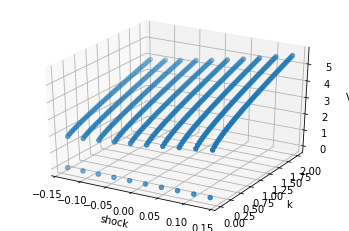

In [64]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, V)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('V');

plt.show()

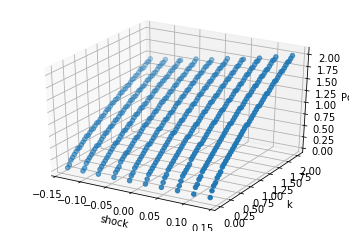

In [65]:
## plot the policy function k'
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, pol)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('Pol');

plt.show()

<Figure size 360x360 with 0 Axes>

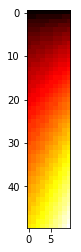

<Figure size 360x360 with 0 Axes>

In [66]:
#print(pol)
fig = plt.figure()
plt.imshow(pol, cmap='hot', interpolation='nearest')
plt.figure(figsize=(5,5))
#plt.show()

In [67]:
@njit
def solve_entrant(params, nk, k_grid, V):
    
    θ, ν, δ, β, ϕ = params
    
    V_0 = np.zeros(10)
    pol_0 = np.zeros_like(V_0)
    
    for ee in range(10):
        max_V = -9999999999999
        idx = 0

        for jj in range(nk):
            kp = k_grid[jj]

            EV = np.dot(V[jj,:],MC[ee,:])
            maxim_val = -kp + β * EV

            if maxim_val > max_V:
                max_V = maxim_val
                idx = jj

        V_0[ee] = max_V
        if max_V >= 0:
            pol_0[ee] = k_grid[int(idx)]
    
    return V_0, pol_0

In [68]:
V_0, pol_0 = solve_entrant(params, nk, k_grid, V)
print(V_0)
print(pol_0)

[1.91532935 1.99886167 2.10326964 2.22165645 2.35405639 2.50195361
 2.66698515 2.85052889 3.04734528 3.23021662]
[0.70040816 0.8222449  0.94408163 1.06591837 1.26897959 1.47204082
 1.71571429 2.         2.         2.        ]


**EXERCISE 4**

In [69]:
@njit
def solve_ex4(nk, k_grid, w, params, c_e, x_stat):
    
    V, pol = solve_incum(w, params, nk, k_grid)
    
    V_0, pol_0 = solve_entrant(params, nk, k_grid, V)
    
    integr = np.dot(x_stat[:],V_0[:])
    
    objective = c_e - integr
    
    return objective

In [73]:
@njit
def run_fun(w):
    nk = 50
    k_low = 0.01 
    k_high = 2
    k_grid = np.linspace(k_low, k_high, nk)
    
    params = θ, ν, δ, β, ϕ
    
    fun_res = solve_ex4(nk, k_grid, w, params, 0.1, x_stat)
    
    return fun_res

In [77]:
from quantecon import optimize
#fun = lambda w: solve_ex4(nk, k_grid, w, params, 0.1, x_stat)
#w_star = optimize.root_finding.newton(run_fun, w_rep)
w_star = optimize.root_finding.newton_secant(run_fun, w_rep)

the V difference is: 9.889443973243317e-05
the V difference is: 9.89996067728427e-05
the V difference is: 9.745201724964403e-05
the V difference is: 9.722564405523215e-05
the V difference is: 9.656985733119683e-05
the V difference is: 9.681914140546866e-05
the V difference is: 9.910636640420023e-05
the V difference is: 9.626453749422836e-05
the V difference is: 9.899616417197166e-05
the V difference is: 9.90192720702332e-05
the V difference is: 9.902088921487362e-05


In [83]:
print(w_star.root)
w_starr = w_star.root

1.265796311722913


**EXERCISE 5**

In [84]:
V, pol = solve_incum(w_starr, params, nk, k_grid)

the V difference is: 9.902088917401741e-05


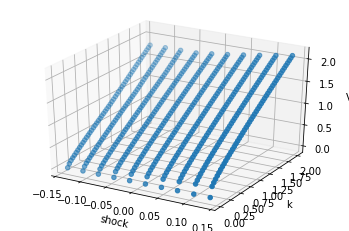

In [85]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, V)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('V');

plt.show()

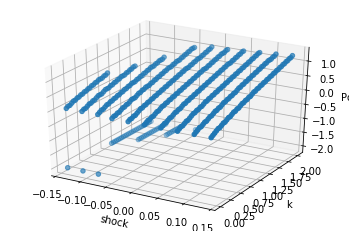

In [86]:
## plot the policy function k'
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, pol)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('Pol');

plt.show()

In [87]:
def closest_gridpt(grid, point_in):
    pt_index  = np.nanargmin((point_in-grid)**2)
    
    return pt_index

In [88]:
closept = np.zeros_like(pol)
for ee in range(10):
    for jj in range(nk):
        closept[jj,ee] = closest_gridpt(k_grid, pol[jj,ee])

#print(closept)

In [89]:
@njit
def measure_G(w, params, nk, k_grid, m, NoExit, MC, closept, x_stat):
    eps = 0.0001
    max_iter = 1000
    
    crit = 1
    itr = 0
    
    θ, ν, δ, β, ϕ = params
    
    G = np.ones(nk*10)*0.002 # 1x(nk*10) vector
    
    while crit > eps and itr < max_iter:
        G_new = np.zeros(nk*10)
        Trans_mat = np.zeros((nk*10,nk*10))
        
        for ee in range(10):
            for ee_p in range(10):
                for jj in range(nk):
                    for jj_p in range(nk):
                        indic = 0
                        if closept[jj,ee] == jj_p+1:
                            indic = 1
                        Trans_mat[jj*10+ee,jj_p*10+ee_p] = MC[ee,ee_p] * indic * NoExit[jj,ee]  # (nk*10) x (nk*10) = ... 
        
        #print("Iteration", itr, ": row sum is", np.sum(Trans_mat[1,:]))
        
        G_new = np.dot(G,Trans_mat) # ((1) x (nk*10)) =  ((1) x (nk*10)) * ((nk*10) x (nk*10))      
        #G_new = np.reshape(G_new, (nk,10))
        
        G_fin = np.zeros(nk*10)
        for ff in range(10):
            for kk in range(nk):
                G_fin[kk*10+ff] = G_new[kk*10+ff] + m*x_stat[ff] 
        #G_new = np.reshape(G_new, nk*10)
        
        crit = np.max(np.abs(G - G_fin))
        print("Iteration", itr, ": error is", crit)
        G = G_fin.copy()
        itr += 1
                 
    return G

In [90]:
NoExit = np.where(pol > 0,1,0)
stat_G = measure_G(w_star, params, nk, k_grid, 1, NoExit, MC, closept, x_stat)

Iteration 0 : error is 0.2361960162819466
Iteration 1 : error is 0.5915729227461327
Iteration 2 : error is 1.0999305304506761
Iteration 3 : error is 2.107800422924511
Iteration 4 : error is 3.1014022446309384
Iteration 5 : error is 4.001904886464916
Iteration 6 : error is 6.310458749442288
Iteration 7 : error is 8.123879337558861
Iteration 8 : error is 8.43563274714283
Iteration 9 : error is 8.37035186463897
Iteration 10 : error is 8.224250392979151
Iteration 11 : error is 8.063295643776101
Iteration 12 : error is 7.901727400955465
Iteration 13 : error is 7.744030047708108
Iteration 14 : error is 7.591501079489575
Iteration 15 : error is 7.444259538932087
Iteration 16 : error is 7.301992817253733
Iteration 17 : error is 7.164254362931175
Iteration 18 : error is 7.030584723602132
Iteration 19 : error is 6.900559085572766
Iteration 20 : error is 6.830618016790993
Iteration 21 : error is 6.7888419173758905
Iteration 22 : error is 6.739922071325822
Iteration 23 : error is 6.684874008949848

Iteration 209 : error is 0.18543194682416697
Iteration 210 : error is 0.18171757858578985
Iteration 211 : error is 0.178077610967307
Iteration 212 : error is 0.1745105538035432
Iteration 213 : error is 0.1710149467667179
Iteration 214 : error is 0.16758935876998748
Iteration 215 : error is 0.16423238738281043
Iteration 216 : error is 0.16094265825637422
Iteration 217 : error is 0.15771882456368758
Iteration 218 : error is 0.15455956644740354
Iteration 219 : error is 0.15146359048111435
Iteration 220 : error is 0.14842962914030977
Iteration 221 : error is 0.1454564402838514
Iteration 222 : error is 0.14254280664601993
Iteration 223 : error is 0.1396875353389646
Iteration 224 : error is 0.13688945736447522
Iteration 225 : error is 0.13414742713604255
Iteration 226 : error is 0.1320340978532215
Iteration 227 : error is 0.12995278486556572
Iteration 228 : error is 0.12790187590510982
Iteration 229 : error is 0.12588098803453818
Iteration 230 : error is 0.12388974145852671
Iteration 231 : e

Iteration 437 : error is 0.0035443002062720552
Iteration 438 : error is 0.0034811867627126958
Iteration 439 : error is 0.003419179650819615
Iteration 440 : error is 0.003358259872555891
Iteration 441 : error is 0.00329840874690035
Iteration 442 : error is 0.003239607905044295
Iteration 443 : error is 0.0031818392851619137
Iteration 444 : error is 0.0031250851278628033
Iteration 445 : error is 0.0030693279707065813
Iteration 446 : error is 0.0030145506441385805
Iteration 447 : error is 0.002960736266118147
Iteration 448 : error is 0.0029078682380259124
Iteration 449 : error is 0.002855930239661575
Iteration 450 : error is 0.0028049062250659063
Iteration 451 : error is 0.0027547804178311708
Iteration 452 : error is 0.002705537306894712
Iteration 453 : error is 0.0026571616423325395
Iteration 454 : error is 0.0026096384307550125
Iteration 455 : error is 0.0025629529314414867
Iteration 456 : error is 0.002517090652446541
Iteration 457 : error is 0.0024720373458535505
Iteration 458 : error 

In [181]:
#print(stat_G)

In [91]:
stat_Gb = np.reshape(stat_G, (nk,10))
#print(stat_Gb)

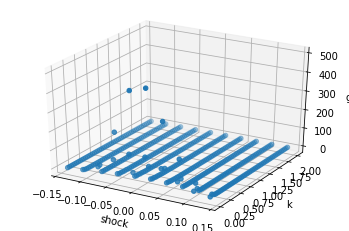

In [92]:
## plot the function g(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, stat_Gb)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('g');

plt.show()

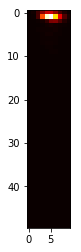

In [93]:
plt.imshow(stat_Gb, cmap='hot', interpolation='nearest')
plt.show()

In [104]:
#print(closept)

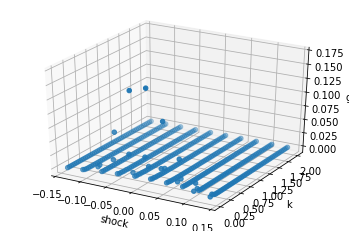

In [94]:
stat_Gc = stat_Gb/np.sum(stat_Gb)
## plot the function g(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, stat_Gc)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('g');

plt.show()

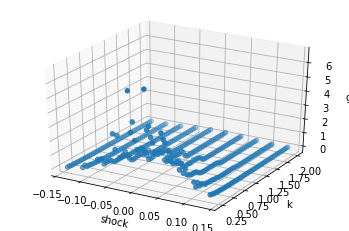

In [96]:
## plot the function g(k,ϵ)
#x_grid = np.linspace(x[0], x[9], 10)
#y_grid = np.linspace(k_low, k_high, nk)

#xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx[5:], yyy[5:], stat_Gb[5:])
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('g');

plt.show()